In [ ]:
import os

import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd
import seaborn as sns

import rasterio
import rasterio.plot

import shapely
from shapely.geometry.point import Point

from matplotlib import pyplot as plt
from matplotlib.path import Path
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib import gridspec as gridspec
import matplotlib.patheffects as patheffects

import contextily as cx
from tqdm import tqdm

import IR_processing_utils

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 7

In [2]:

path2IR_rasters = [r"G:\! Data\IFA\! campaigns\202503 Ayhal\Mavic_IR_imaging\geotiffs\20250328_morning_t31.tif", 
                   r"G:\! Data\IFA\! campaigns\202503 Ayhal\Mavic_IR_imaging\geotiffs\20250327_evn_t31.tif"]

survey_names = ['28 марта, 11:00', '27 марта, 15:00']                   



In [3]:


rasters = []

for i, path in enumerate(path2IR_rasters):

    raster = {}

    display(path)

    src = rasterio.open(path)
    
    data = src.read() 
    values = data [0,:,:]
    mask = data [1,:,:]

    n = np.sum (mask > 0)
    #display(n)
    

    raster['fname'] = os.path.basename(path)
    raster['name'] = survey_names[i]
    raster['values'] = ma.masked_array(values, ~mask.astype(bool))
    raster['extent'] = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    raster['lons'], raster['lats'] =  IR_processing_utils.get_subarray_coords_rio (values.shape, src.crs, src.transform)
    raster['vmin2draw'] = np.nanpercentile(raster['values'].copy().filled(np.nan).flatten(), 1)
    raster['vmax2draw'] = np.nanpercentile(raster['values'].copy().filled(np.nan).flatten(), 99) #np.percentile(np.copy(raster['values'].flatten()), 99)
    rasters.append(raster)
    #break

'G:\\! Data\\IFA\\! campaigns\\202503 Ayhal\\Mavic_IR_imaging\\geotiffs\\20250328_morning_t31.tif'

'G:\\! Data\\IFA\\! campaigns\\202503 Ayhal\\Mavic_IR_imaging\\geotiffs\\20250327_evn_t31.tif'

In [4]:
min_lon = np.min([r['extent'][0] for r in rasters])
max_lon = np.max([r['extent'][1] for r in rasters])
min_lat = np.min([r['extent'][2] for r in rasters])
max_lat = np.max([r['extent'][3] for r in rasters])

ir_lon_lim = np.array([min_lon - 0.01 * (max_lon - min_lon), max_lon + 0.01 * (max_lon - min_lon)])
ir_lat_lim = np.array([min_lat - 0.01 * (max_lat - min_lat), max_lat + 0.01 * (max_lat - min_lat)])



In [8]:
import glob
profile_dirs="D:/!Work\Drones/! scripts/MATLAB_new/pics_Alrosa_vert/flights/"

profile_files = glob.glob(profile_dirs + '*.csv')

crd = []

for file in profile_files:
    df = pd.read_csv(file, sep=';')
    if 'DJI_lon' in df.columns:
        crd.append([df.DJI_lon.median(), df.DJI_lat.median()])

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\mvar9\AppData\Local\Temp\ipykernel_16224\32317648.py:2: SyntaxWarning: invalid escape sequence '\D'
  profile_dirs="D:/!Work\Drones/! scripts/MATLAB_new/pics_Alrosa_vert/flights/"


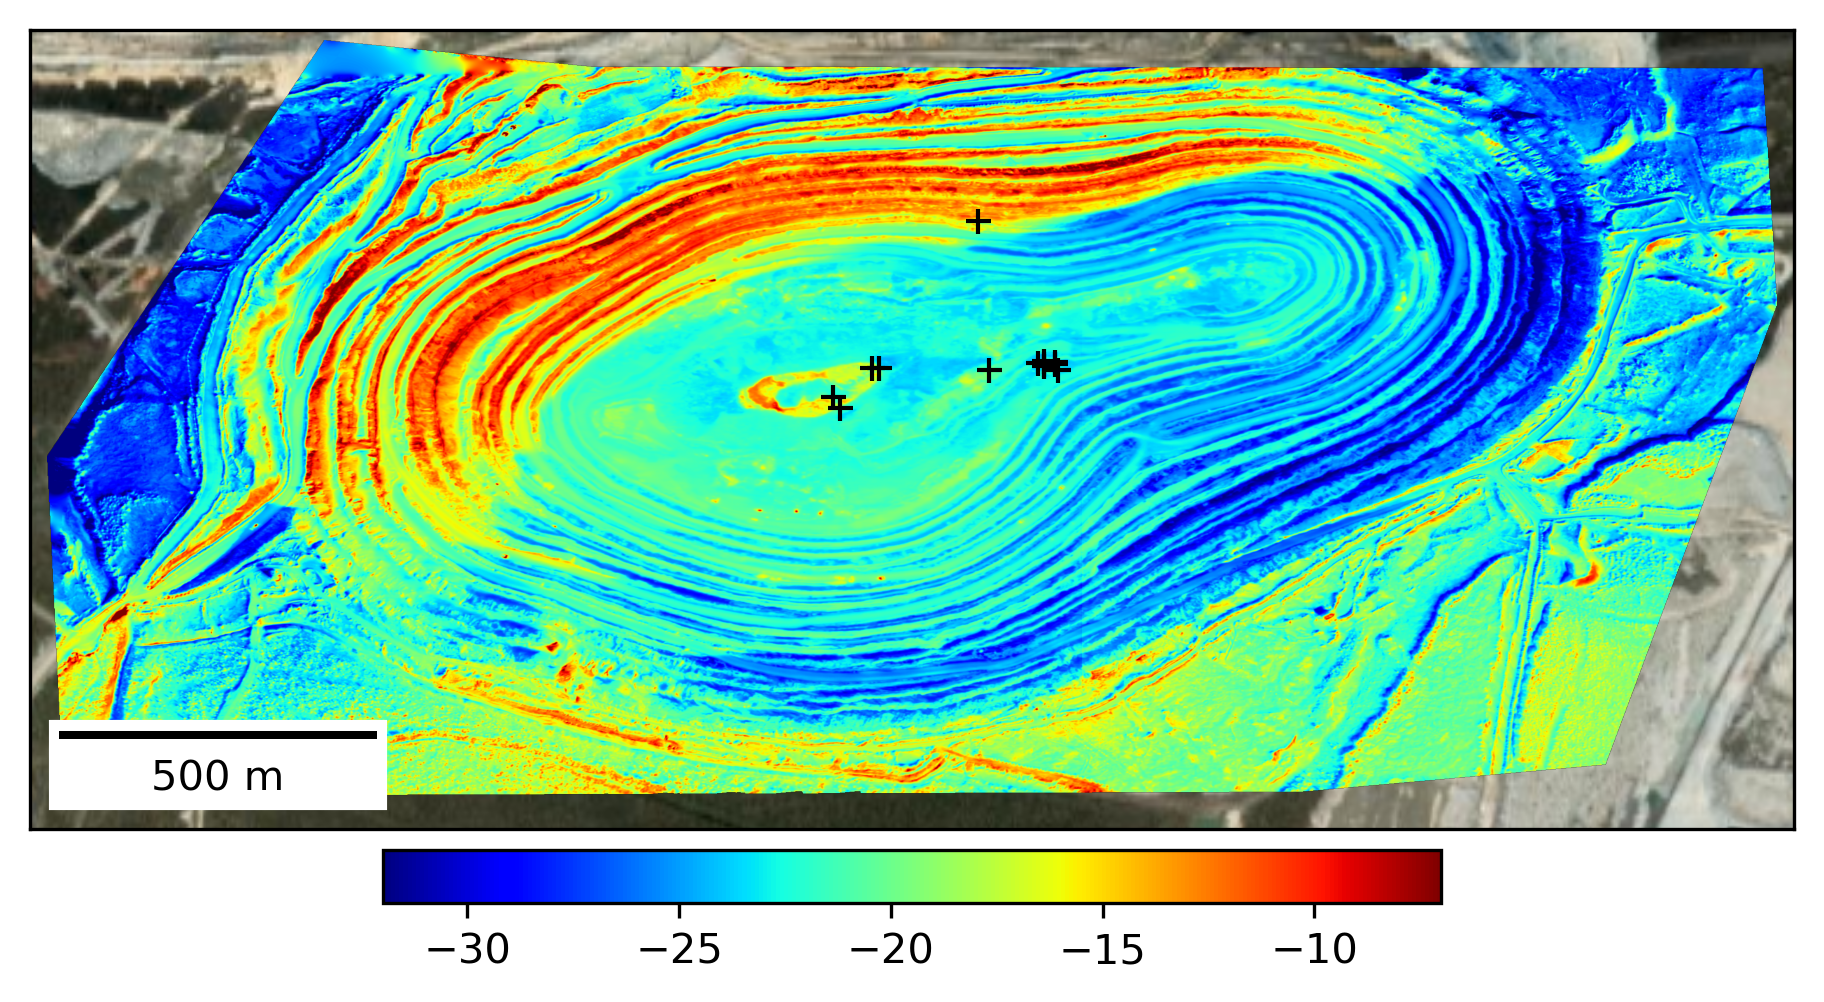

In [10]:
plt.rcParams['font.size'] = 10
pics_dir = 'pics_IR_Ayhal'
if not os.path.isdir (pics_dir):
    os.mkdir(pics_dir)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[0], colors[1] = colors[1], colors[0]
colors[1], colors[2] = colors[2], colors[1]


#colors = ['red', 'green', 'orange', 'green']

for i, raster in enumerate (rasters):

    fig = plt.figure(figsize = (6, 4))
    
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

    plt.subplots_adjust(left=0.01, right=0.99, bottom=0.1, top=0.99)

    plt.xlim(ir_lon_lim)
    plt.ylim(ir_lat_lim)
    try:
        cx.add_basemap(plt.gca(), source = cx.providers.Esri.WorldImagery, crs = 4326, attribution_size = 2, attribution = '')              
    except Exception as err:
        print ('basemap is not availible')

    im = plt.imshow (raster['values'], extent= raster['extent'], cmap = 'jet',
                     vmin=-32, vmax=-7)
    
    for c in crd:
        plt.plot (c[0], c[1], '+k')
    
    points = gpd.GeoSeries([Point(161, ir_lat_lim.mean()), Point(162, ir_lat_lim.mean())], crs=4326)  # Geographic WGS 84 - degrees
    points = points.to_crs(32619)
    distance_meters = points[0].distance(points[1])

    scalebar = ScaleBar(distance_meters, length_fraction=0.2, location = 'lower left', pad = 0.2, border_pad = 0.5, rotation='horizontal-only') #, units = "km", )
    
    plt.gca().add_artist(scalebar)                     

    pos = plt.gca().get_position().bounds
    plt.gca().set_aspect(1/np.cos(np.degrees(ir_lat_lim.mean())))

    plt.colorbar(im, location = 'bottom', orientation='horizontal', shrink = 0.6, pad=0.02)
    
    plt.savefig ((pics_dir + '/' + raster['name'] + '_new.png').replace(':', ''))
    break
    

#sys.exit()